In [1]:
import os
from record_parser import RecordParser
if os.path.exists('records.db'):
    os.remove('records.db')
    
rp = RecordParser('test_data.txt')
rp.parse()

In [2]:
from db_mngr import DBMngr
db = DBMngr()

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

from datetime import date, timedelta

In [3]:
work_days = []
workloads = []

for row in db.cur.execute('''Select date, sum(duration)/60.0 
                        From records 
                        Where activity not in ('sleep')
                        Group By date 
                        Order By date
                        '''):
    work_days.append(row[0])
    workloads.append(row[1])

workloads = np.array(workloads)

def get_offset_from_beginning(days, beginning=None):
    
    days = np.array(
        [date(year=day//10**4, month=day//100%100, day=day%100) for day in days]
    )

    if beginning is None:
        beginning = days[0]
    else:
        beginning = date(year=beginning//10**4, month=beginning//100%100, day=beginning%100)
    
    offsets = days - beginning

    return np.array([offset.days for offset in offsets])

workday_offsets = get_offset_from_beginning(work_days)

cal_days = np.arange(0, workday_offsets[-1]+1)

cal_workloads = np.zeros_like(cal_days, dtype=float)
cal_workloads[workday_offsets] = workloads

avg_workload = np.average(cal_workloads)

padding = np.zeros_like(cal_workloads)
padding[cal_workloads==0] += avg_workload
padded_cal_workloads = cal_workloads + padding

In [4]:
sleep_days = []
sleeploads = []

for row in db.cur.execute('''Select date, sum(duration)/60.0 
                        From records 
                        Where activity = 'sleep'
                        Group By date 
                        Order By date
                        '''):
    sleep_days.append(row[0])
    sleeploads.append(row[1])

sleeploads = np.array(sleeploads)

sleepday_offsets = get_offset_from_beginning(sleep_days, work_days[0])

cal_sleeploads = np.zeros_like(cal_days, dtype=float)
cal_sleeploads[sleepday_offsets] = sleeploads

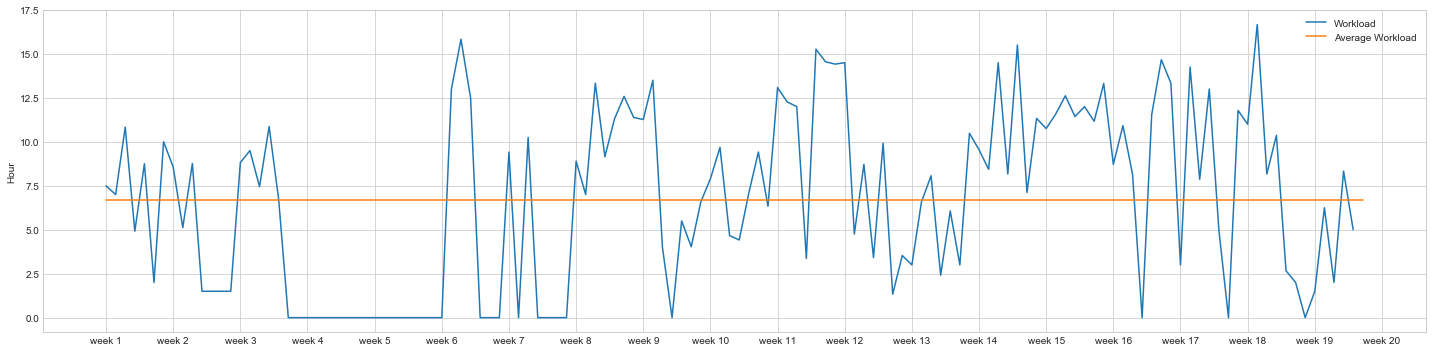

In [5]:
fig = plt.figure(figsize=(20,5))
ax = plt.axes()
ax.plot(cal_days, cal_workloads, label='Workload')
ax.plot([0, len(cal_days)], [avg_workload,avg_workload], label='Average Workload')

ax.grid(True)
ax.legend(frameon=False)

def format_func(value, tick_number):
    # find number of multiples 7
    N = int(np.round(value / 7))
    return 'week {}'.format(str(N+1))

ax.xaxis.set_major_locator(plt.MultipleLocator(7))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.set_ylabel('Hour')

plt.tight_layout()

plt.savefig('Work.png')

In [6]:
sleep_start = np.nonzero(cal_sleeploads)[0][0]
sleep_end = np.nonzero(cal_sleeploads)[0][-1]
avg_sleepload = np.average(sleeploads)

padding = np.zeros_like(cal_sleeploads, dtype=float)
padding[cal_sleeploads==0] += avg_sleepload
padded_cal_sleeploads = cal_sleeploads + padding

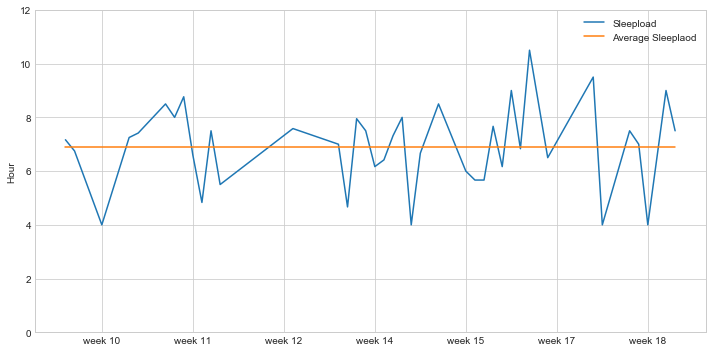

In [7]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(cal_days[sleepday_offsets], sleeploads, label='Sleepload')
ax.plot([sleep_start, sleep_end], [avg_sleepload, avg_sleepload], label='Average Sleeplaod')
ax.grid(True)
ax.legend(frameon=False)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_ylim(0,12)
ax.set_ylabel('Hour')

plt.tight_layout()

plt.savefig('Sleep.png')

In [8]:
padded_cal_work_and_sleep_load = padded_cal_workloads + padded_cal_sleeploads

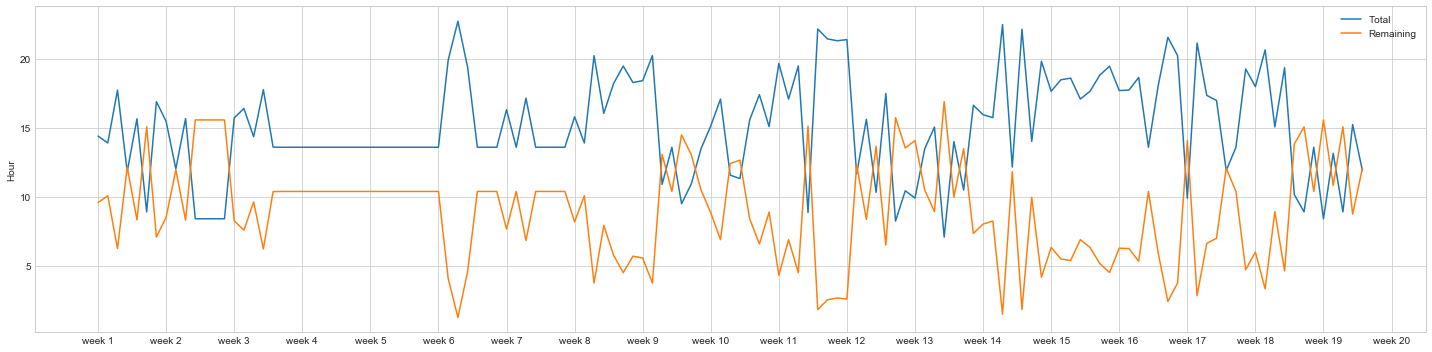

In [9]:
fig = plt.figure(figsize=(20,5))
ax = plt.axes()

ax.plot(cal_days, padded_cal_work_and_sleep_load, label='Total')
ax.plot(cal_days, 24.0-padded_cal_work_and_sleep_load, label='Remaining')
ax.grid(True)
ax.legend(frameon=False)
ax.xaxis.set_major_locator(plt.MultipleLocator(7))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.set_ylabel('Hour')
plt.tight_layout()

plt.savefig('Total.png')

In [10]:
# import sys

# sys.stdout = open('output.txt','wt')

In [11]:
total_days = len(cal_workloads)
print('There are {} days in this semester.'.format(total_days))
print('I work {:2.1f} hours on average, the standard deviation is {:2.1f} hour.\n'.format(
    np.average(cal_workloads), np.std(cal_workloads)))


print('When work over average, I work {:3.1f} more hours in average, specifically:'.format(
    np.average(workloads[workloads > avg_workload] - avg_workload)))
print('{:3.0%} days, I work over average.'.format(
    np.sum(cal_workloads > avg_workload)/total_days))

for i in range(7,16):
    print('{:3.0%} days, I work over {:2d} hours.'.format(
        np.sum(cal_workloads > i)/total_days, i))
    
print('\nWhen work over average, I work {:3.1f} more hours in average, specifically:'.format(
    np.average(workloads[workloads > avg_workload] - avg_workload)))
for i in range(7,0,-1):
    print('{:3.0%} days, I work below or equal to {} hours.'.format(
        np.sum(cal_workloads <= i)/total_days, i))
print('{:3.0%} days, I do not work at all.\n'.format(
    np.sum(cal_workloads == 0)/total_days, avg_workload))


There are 131 days in this semester.
I work 6.7 hours on average, the standard deviation is 5.0 hour.

When work over average, I work 4.1 more hours in average, specifically:
53% days, I work over average.
51% days, I work over  7 hours.
47% days, I work over  8 hours.
37% days, I work over  9 hours.
31% days, I work over 10 hours.
24% days, I work over 11 hours.
16% days, I work over 12 hours.
11% days, I work over 13 hours.
 8% days, I work over 14 hours.
 3% days, I work over 15 hours.

When work over average, I work 4.1 more hours in average, specifically:
49% days, I work below or equal to 7 hours.
43% days, I work below or equal to 6 hours.
41% days, I work below or equal to 5 hours.
36% days, I work below or equal to 4 hours.
33% days, I work below or equal to 3 hours.
29% days, I work below or equal to 2 hours.
22% days, I work below or equal to 1 hours.
22% days, I do not work at all.



In [12]:
print('I slept {:2.1f} hours on average, the standard deviation is {:2.1f} hour, specifically:'.format(
    np.average(sleeploads), np.std(sleeploads)))

for i in range(8,4,-1):
    print('{:3.0%} days, I sleep less than {} hours.'.format(
        np.sum(sleeploads < i)/len(sleeploads), i))
    
print()
for i in range(8,11):
    print('{:3.0%} days, I sleep more than {} hours.'.format(
        np.sum(sleeploads >= i)/len(sleeploads), i))

I slept 6.9 hours on average, the standard deviation is 1.5 hour, specifically:
78% days, I sleep less than 8 hours.
45% days, I sleep less than 7 hours.
22% days, I sleep less than 6 hours.
15% days, I sleep less than 5 hours.

22% days, I sleep more than 8 hours.
10% days, I sleep more than 9 hours.
 2% days, I sleep more than 10 hours.


In [13]:
activities = {}
for row in db.cur.execute('''Select activity, sum(duration)/60.0
                             From records
                             WHERE activity not in ('sleep')
                             Group By activity
                             Order By sum(duration) DESC'''):
    activities[row[0]] = row[1]
    
# combine course and corressponding experiments
for key in [key for key in activities.keys()]:
    if key.endswith(' exp'):
        activities[key[:-4]] += activities[key]
        activities.pop(key)
        
# combile cs-learning activities
cs_self_learning_activities = ['study', 'py', 'design pattern', 'pyqt', 'code complete', 'bomb lab', 'diagram', 'gfw', 'linux']
activities['self learning'] = 0.
for key in cs_self_learning_activities:
    activities['self learning'] += activities[key]
    activities.pop(key)
    
# combine coding activities
coding_activitys = ['coding', 'hashtree']
for key in coding_activitys:
    if key != 'coding':
        activities['coding'] += activities[key]
        activities.pop(key)
        
# sort activities according to duration
activities = {k: v for k, v in sorted(activities.items(), key=lambda item: item[1], reverse=True)}
activities.pop('print')
activities.pop('english')

0.5833333333333334

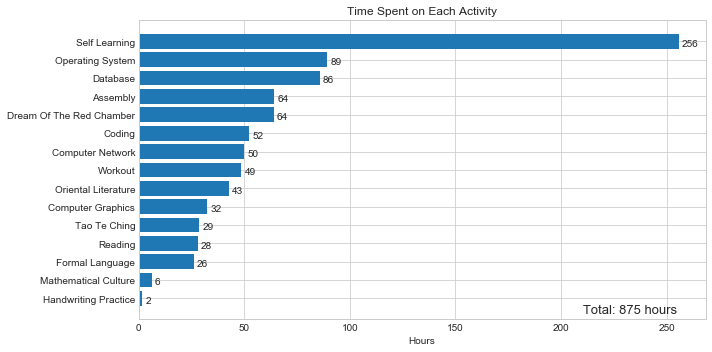

In [14]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

y_pos = np.arange(len(activities))
y_labels = [name.title() for name in activities]

time = activities.values()

ax.barh(y_pos, time, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Hours')
ax.set_title('Time Spent on Each Activity')

# label times on the right
for i, v in enumerate(time):
    ax.text(v + 1.5, i + .25, '{:.0f}'.format(v))
    
# total
total = sum(time)
ax.text(0.95, 0.01, 
        'Total: {:.0f} hours'.format(total),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=13
       )

plt.tight_layout()
plt.savefig('Time-Spend-On-Each-Activity.png')
